# 01 Preliminary EDA for Data Understanding (Lung1)

This notebook inventories NSCLC-Radiomics (Lung1) raw data, validates CT and RTSTRUCT availability, samples key DICOM metadata, checks CT↔RTSTRUCT FrameOfReference alignment on a subset, and confirms clinical CSV joinability. 

Run this notebook after placing the NSCLC-Radiomics (Lung1) raw data in the `data/raw` folder, including both the downloaded manifest output and the clinical metadata.  

Running this notebook confirms readiness for the "Exploration" tasks in `plan.md`.

## Setup

Confirms basic files exist and creates helper functions

In [1]:
# Setup
from __future__ import annotations

from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import os
import json
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import SimpleITK as sitk
from rich.console import Console
from rich.pretty import pprint; 

# Display opts
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)
sns.set_context("notebook")

# Paths
ROOT = Path("/Users/kai/workspace/capstone").resolve()
RAW = ROOT / "data" / "raw"
RAW_DICOM_ROOT = RAW / "NSCLC-Radiomics"
MANIFEST_CSV = RAW / "metadata.csv"
CLINICAL_CSV = RAW / "NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"

# Config
COVERAGE_THRESHOLD = 0.95
JOIN_THRESHOLD = 0.95
CT_SAMPLE_MAX_PATIENTS = 30  # bound heavy IO
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

@dataclass
class SeriesRecord:
    subject_id: str
    modality: str
    num_images: Optional[int]
    manufacturer: Optional[str]
    series_description: Optional[str]
    file_location: Path


def resolve_series_dir(file_location: str | Path) -> Path:
    # Manifest uses './NSCLC-Radiomics/...' roots; normalize to absolute
    loc = str(file_location).lstrip("./")
    full_path = RAW / loc
    return full_path


def safe_first_dcm_in_dir(series_dir: Path) -> Optional[Path]:
    if not series_dir.exists():
        return None
    # Try common DICOM patterns
    for pattern in ("*.dcm", "*.*"):
        matches = list(series_dir.glob(pattern))
        if matches:
            # Prefer actual DICOM files by quick check of magic
            for candidate in matches:
                try:
                    ds = pydicom.dcmread(str(candidate), stop_before_pixels=True)
                    if getattr(ds, "SOPClassUID", None) is not None:
                        return candidate
                except Exception:
                    continue
            return matches[0]
    # Fallback deep search
    for candidate in series_dir.rglob("*.dcm"):
        try:
            ds = pydicom.dcmread(str(candidate), stop_before_pixels=True)
            if getattr(ds, "SOPClassUID", None) is not None:
                return candidate
        except Exception:
            continue
    return None


def extract_ct_tags(ds: pydicom.dataset.FileDataset) -> Dict[str, Optional[str]]:
    def get(attr: str) -> Optional[str]:
        return getattr(ds, attr, None)
    # PixelSpacing may be list-like
    px = get("PixelSpacing")
    if isinstance(px, (list, tuple)):
        px = [float(x) for x in px]
    st = get("SliceThickness")
    try:
        st = float(st) if st is not None else None
    except Exception:
        pass
    kernel = get("ConvolutionKernel")
    if isinstance(kernel, (list, tuple)):
        kernel = "/".join(map(str, kernel))
    tags = {
        "Manufacturer": get("Manufacturer"),
        "SeriesInstanceUID": get("SeriesInstanceUID"),
        "FrameOfReferenceUID": get("FrameOfReferenceUID"),
        "PixelSpacing": px,
        "SliceThickness": st,
        "ConvolutionKernel": kernel,
    }
    return tags


def extract_rtstruct_for(ds: pydicom.dataset.FileDataset) -> Optional[str]:
    # RTSTRUCT FoR via ReferencedFrameOfReferenceSequence
    try:
        seq = ds.ReferencedFrameOfReferenceSequence
        if seq and len(seq) > 0:
            return getattr(seq[0], "FrameOfReferenceUID", None)
    except Exception:
        pass
    # Fallback attribute if present
    return getattr(ds, "FrameOfReferenceUID", None)


def choose_preferred_ct_series(ct_rows: pd.DataFrame) -> Optional[pd.Series]:
    if ct_rows.empty:
        return None
    # Prefer max Number of Images; tie-break by earliest Study Date if available
    rows = ct_rows.copy()
    def to_int(x):
        try:
            return int(x)
        except Exception:
            return -1
    rows["_num_images"] = rows["Number of Images"].apply(to_int)
    rows = rows.sort_values(["_num_images"], ascending=[False])
    return rows.iloc[0]

print("ROOT:", ROOT)
for p in (RAW, RAW_DICOM_ROOT, MANIFEST_CSV, CLINICAL_CSV):
    print("exists", str(p), p.exists())


ROOT: /Users/kai/workspace/capstone
exists /Users/kai/workspace/capstone/data/raw True
exists /Users/kai/workspace/capstone/data/raw/NSCLC-Radiomics True
exists /Users/kai/workspace/capstone/data/raw/metadata.csv True
exists /Users/kai/workspace/capstone/data/raw/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv True


### Interpretation

* This setup cell prints the project root and verifies that the expected raw data paths and CSV files exist. 
* If any value shows `False`, the dataset is incomplete or paths are misconfigured; fix paths or place the missing files before proceeding.


## Manifest/Clinical Data Availability

In [2]:
# Load manifests
manifest = pd.read_csv(MANIFEST_CSV)
clinical = pd.read_csv(CLINICAL_CSV)

# Normalize column names we rely on
required_cols = [
    "Subject ID",
    "Modality",
    "Number of Images",
    "Manufacturer",
    "Series Description",
    "File Location",
]
missing_cols = [c for c in required_cols if c not in manifest.columns]
if missing_cols:
    raise ValueError(f"Manifest missing expected columns: {missing_cols}\nHave: {list(manifest.columns)}")

print("Manifest shape:", manifest.shape)
print("Clinical shape:", clinical.shape)
print("Unique subjects in manifest:", manifest["Subject ID"].nunique())
print("Modalities counts:\n", manifest["Modality"].value_counts())

# Quick peek
display(manifest.head(3))
display(clinical.head(3))


Manifest shape: (1265, 17)
Clinical shape: (422, 10)
Unique subjects in manifest: 422
Modalities counts:
 Modality
RTSTRUCT    422
CT          422
SEG         421
Name: count, dtype: int64


,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.2.276.0.7230010.3.1.3.2323910823.20524.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,NaN,09-18-2008,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,17.89 MB,./NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID...,2025-11-08T16:47:08.997
1,1.3.6.1.4.1.32722.99.99.2279381215866080725084...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,NaN,09-18-2008,NaN,Varian Medical Systems,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.51 MB,./NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID...,2025-11-08T16:47:09.414
2,1.2.276.0.7230010.3.1.3.2323910823.11504.15972...,NSCLC-Radiomics,NO,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,NaN,01-01-2014,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,22.22 MB,./NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID...,2025-11-08T16:47:11.4


,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1


### Interpretation

* This loads the TCIA manifest and the clinical CSV. 
* Use the printed shapes and `value_counts()` to confirm we have many rows and the expected modalities (`CT`, `RTSTRUCT`, optional `SEG`). 
* An error here (missing columns) means the manifest format is unexpected.

## Per-Subject Inventory

In [3]:
# Build per-patient inventory (CT / RTSTRUCT / SEG)
modalities = manifest[["Subject ID", "Modality", "Number of Images", "Manufacturer", "Series Description", "File Location"]].copy()
modalities["series_dir"] = modalities["File Location"].apply(resolve_series_dir)

# Partition by modality
df_ct = modalities[modalities["Modality"] == "CT"].copy()
df_rs = modalities[modalities["Modality"].str.contains("RTSTRUCT", na=False)].copy()
df_seg = modalities[modalities["Modality"] == "SEG"].copy()

subjects = sorted(modalities["Subject ID"].unique())

# Build minimal inventory per subject
from collections import defaultdict
inv = []
for sid in subjects:
    ct_rows = df_ct[df_ct["Subject ID"] == sid]
    rs_rows = df_rs[df_rs["Subject ID"] == sid]
    seg_rows = df_seg[df_seg["Subject ID"] == sid]
    inv.append({
        "Subject ID": sid,
        "has_CT": not ct_rows.empty,
        "has_RTSTRUCT": not rs_rows.empty,
        "has_SEG": not seg_rows.empty,
        "num_CT_series": int(ct_rows.shape[0]),
        "num_RS_series": int(rs_rows.shape[0]),
        "num_SEG_series": int(seg_rows.shape[0]),
    })

inventory = pd.DataFrame(inv)
display(inventory.head(10))
print("Total subjects:", len(inventory))
print("Subjects with CT:", int(inventory["has_CT"].sum()))
print("Subjects with RTSTRUCT:", int(inventory["has_RTSTRUCT"].sum()))
print("Subjects with both CT & RTSTRUCT:", int(((inventory["has_CT"]) & (inventory["has_RTSTRUCT"])) .sum()))



,Subject ID,has_CT,has_RTSTRUCT,has_SEG,num_CT_series,num_RS_series,num_SEG_series
0,LUNG1-001,True,True,True,1,1,1
1,LUNG1-002,True,True,True,1,1,1
2,LUNG1-003,True,True,True,1,1,1
3,LUNG1-004,True,True,True,1,1,1
4,LUNG1-005,True,True,True,1,1,1
5,LUNG1-006,True,True,True,1,1,1
6,LUNG1-007,True,True,True,1,1,1
7,LUNG1-008,True,True,True,1,1,1
8,LUNG1-009,True,True,True,1,1,1
9,LUNG1-010,True,True,True,1,1,1


Total subjects: 422
Subjects with CT: 422
Subjects with RTSTRUCT: 422
Subjects with both CT & RTSTRUCT: 422


### Interpretation 

* The inventory table shows, per `Subject ID`, whether CT (`has_CT`) and RTSTRUCT (`has_RTSTRUCT`) are present and how many series exist. 
* We expect most patients to have both; any `False` flags indicate gaps to investigate.

## Coverage Requirements

In [4]:
# Coverage metrics and assertions (CT + RTSTRUCT)
num_subjects = len(inventory)
num_ct = int(inventory["has_CT"].sum())
num_rs = int(inventory["has_RTSTRUCT"].sum())
num_both = int(((inventory["has_CT"]) & (inventory["has_RTSTRUCT"])) .sum())

coverage_ct = num_ct / num_subjects if num_subjects else 0.0
coverage_rs = num_rs / num_subjects if num_subjects else 0.0
coverage_both = num_both / num_subjects if num_subjects else 0.0

summary = {
    "num_subjects": num_subjects,
    "coverage_ct": round(coverage_ct, 3),
    "coverage_rtstruct": round(coverage_rs, 3),
    "coverage_ct_and_rtstruct": round(coverage_both, 3),
}
pprint(summary)

missing_ct = inventory.loc[~inventory["has_CT"], "Subject ID"].tolist()
missing_rs = inventory.loc[~inventory["has_RTSTRUCT"], "Subject ID"].tolist()

print("Missing CT (first 10):", missing_ct[:10])
print("Missing RTSTRUCT (first 10):", missing_rs[:10])

assert coverage_ct >= COVERAGE_THRESHOLD, f"CT coverage {coverage_ct:.2%} < threshold {COVERAGE_THRESHOLD:.0%}"
assert coverage_rs >= COVERAGE_THRESHOLD, f"RTSTRUCT coverage {coverage_rs:.2%} < threshold {COVERAGE_THRESHOLD:.0%}"
assert coverage_both >= COVERAGE_THRESHOLD, f"CT+RTSTRUCT coverage {coverage_both:.2%} < threshold {COVERAGE_THRESHOLD:.0%}"


{'num_subjects': 422, 'coverage_ct': 1.0, 'coverage_rtstruct': 1.0, 'coverage_ct_and_rtstruct': 1.0}

Missing CT (first 10): []
Missing RTSTRUCT (first 10): []


### Interpretation

* These coverage metrics quantify how much of the cohort has CT, RTSTRUCT, and both. 
* The assertions enforce minimum coverage thresholds. 
* If an assertion fails, examine the printed missing `Subject ID`s and fix the dataset before continuing.

## Clinical Data Coverage

In [5]:
# Clinical CSV join validation
# Manifest subjects
subjects_manifest = set(inventory["Subject ID"].unique())

# Clinical subjects
if "PatientID" not in clinical.columns:
    raise ValueError("Clinical CSV missing 'PatientID' column")
subjects_clinical = set(clinical["PatientID"].dropna().astype(str).unique())

# Normalize to same ID format (already looks like LUNG1-xxx)
joinable = subjects_manifest & subjects_clinical
join_rate = len(joinable) / len(subjects_manifest) if subjects_manifest else 0.0

pprint({
    "subjects_manifest": len(subjects_manifest),
    "subjects_clinical": len(subjects_clinical),
    "joinable_subjects": len(joinable),
    "join_rate": round(join_rate, 3),
})

# Show first few missing in clinical
missing_in_clinical = sorted(subjects_manifest - subjects_clinical)
print("Missing in clinical (first 10):", missing_in_clinical[:10])

assert join_rate >= JOIN_THRESHOLD, f"Clinical join rate {join_rate:.2%} < threshold {JOIN_THRESHOLD:.0%}"


{'subjects_manifest': 422, 'subjects_clinical': 422, 'joinable_subjects': 422, 'join_rate': 1.0}

Missing in clinical (first 10): []


### Interpretation

* This checks whether clinical records can be joined to imaging subjects. 
* A high `join_rate` means the clinical CSV covers most imaged patients. 
* If the assertion fails, inspect the first missing IDs to identify naming mismatches or missing clinical rows.

## CT Metadata Analysis

Sampling 30 patients for CT metadata...


,Subject ID,SeriesDir,NumImages,Manufacturer,SeriesInstanceUID,FrameOfReferenceUID,PixelSpacing,SliceThickness,ConvolutionKernel
0,LUNG1-403,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.3164445486800054133943...,1.3.6.1.4.1.32722.99.99.3801097939454252422790...,"[0.9765625, 0.9765625]",3.0,B19f
1,LUNG1-012,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,109,"CMS, Inc.",1.3.6.1.4.1.32722.99.99.6548856915427024669919...,1.3.6.1.4.1.32722.99.99.1659251140356443807262...,"[0.9770, 0.9770]",3.0,None
2,LUNG1-348,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,132,SIEMENS,1.3.6.1.4.1.32722.99.99.3104809005727477840573...,1.3.6.1.4.1.32722.99.99.9791701525950172153504...,"[0.9765625, 0.9765625]",3.0,B19f
3,LUNG1-320,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,131,SIEMENS,1.3.6.1.4.1.32722.99.99.2713400057815152127817...,1.3.6.1.4.1.32722.99.99.2662246114654223188655...,"[0.9765625, 0.9765625]",3.0,B19f
4,LUNG1-248,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.3352525197469145845328...,1.3.6.1.4.1.32722.99.99.6743100925919512219745...,"[0.9765625, 0.9765625]",3.0,B41f
5,LUNG1-359,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.3058931863409965859597...,1.3.6.1.4.1.32722.99.99.1472827184333922902365...,"[0.9765625, 0.9765625]",3.0,B19f
6,LUNG1-044,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,99,"CMS, Inc.",1.3.6.1.4.1.32722.99.99.1507877282536873804588...,1.3.6.1.4.1.32722.99.99.2829649433307944513909...,"[0.9770, 0.9770]",3.0,None
7,LUNG1-003,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,107,"CMS, Inc.",1.3.6.1.4.1.32722.99.99.2389222799296192439904...,1.3.6.1.4.1.32722.99.99.2067784634305097085472...,"[0.9770, 0.9770]",3.0,None
8,LUNG1-216,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,134,SIEMENS,1.3.6.1.4.1.32722.99.99.2143675881885239241247...,1.3.6.1.4.1.32722.99.99.2117839321906678219041...,"[0.9765625, 0.9765625]",3.0,B30f
9,LUNG1-086,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,176,SIEMENS,1.3.6.1.4.1.32722.99.99.1637313385502800652839...,1.3.6.1.4.1.32722.99.99.7735060697620594441170...,"[0.9765625, 0.9765625]",3.0,B31f


Vendors:
Manufacturer
SIEMENS      25
CMS, Inc.     5
Name: count, dtype: int64
Kernels:
ConvolutionKernel
B19f    8
B30f    8
None    5
B41f    3
B31f    3
B18f    2
B31s    1
Name: count, dtype: int64


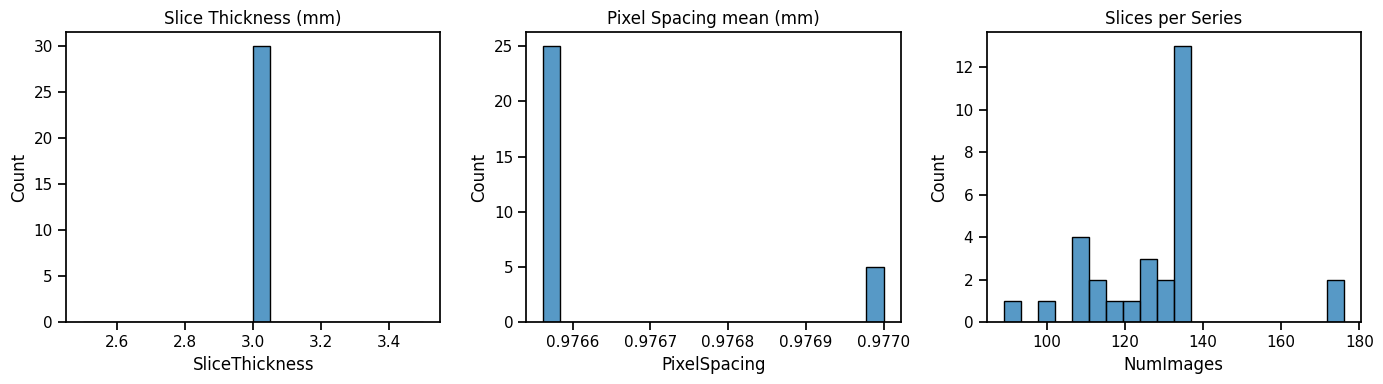

In [6]:
# Sample CT metadata for up to N patients and compute distributions
eligible = inventory[(inventory["has_CT"]) & (inventory["has_RTSTRUCT"])]["Subject ID"].tolist()
random.shuffle(eligible)
sample_subjects = eligible[:CT_SAMPLE_MAX_PATIENTS]
print(f"Sampling {len(sample_subjects)} patients for CT metadata...")

rows = []
for sid in sample_subjects:
    ct_rows = df_ct[df_ct["Subject ID"] == sid]
    chosen = choose_preferred_ct_series(ct_rows)
    if chosen is None:
        continue
    series_dir = chosen["series_dir"]
    dcm_file = safe_first_dcm_in_dir(series_dir)
    if dcm_file is None:
        continue
    try:
        ds = pydicom.dcmread(str(dcm_file), stop_before_pixels=True)
        tags = extract_ct_tags(ds)
        num_images = int(chosen.get("Number of Images", -1)) if pd.notna(chosen.get("Number of Images", None)) else -1
        rows.append({
            "Subject ID": sid,
            "SeriesDir": str(series_dir),
            "NumImages": num_images,
            **tags,
        })
    except Exception as e:
        print(f"WARN: {sid} failed to read CT DICOM: {e}")

ct_sample_df = pd.DataFrame(rows)
display(ct_sample_df.head(10))

# Distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
if not ct_sample_df.empty:
    # Slice thickness
    sns.histplot(ct_sample_df["SliceThickness"].dropna().astype(float), bins=20, ax=axes[0])
    axes[0].set_title("Slice Thickness (mm)")
    # Pixel spacing (mean of in-plane if present)
    def mean_px(x):
        try:
            return float(np.mean(x))
        except Exception:
            return np.nan
    px_mean = ct_sample_df["PixelSpacing"].apply(mean_px)
    sns.histplot(px_mean.dropna(), bins=20, ax=axes[1])
    axes[1].set_title("Pixel Spacing mean (mm)")
    # Num images (slices)
    sns.histplot(ct_sample_df["NumImages"].replace(-1, np.nan).dropna(), bins=20, ax=axes[2])
    axes[2].set_title("Slices per Series")
    plt.tight_layout()
else:
    plt.close(fig)
    print("No CT samples read.")

print("Vendors:")
print(ct_sample_df["Manufacturer"].value_counts(dropna=False))
print("Kernels:")
print(ct_sample_df["ConvolutionKernel"].value_counts(dropna=False).head(15))


### Interpretation

These plots summarize CT acquisition characteristics. 
- Slice Thickness: distribution in millimeters; thicker slices can blur boundaries.
- Pixel Spacing mean: in-plane resolution; smaller is higher detail.
- Slices per Series: proxy for z-coverage/resolution.

Vendor and kernel counts reveal potential scanner/recon biases.

## Frame of Reference Alignment Check (CT vs RTSTRUCT)

In [7]:
# Alignment check: FrameOfReferenceUID CT vs RTSTRUCT (sampled subjects)
if ct_sample_df.empty:
    print("No CT samples to align.")
else:
    results = []
    for sid in ct_sample_df["Subject ID"].unique():
        # CT slice FoR
        ct_row = ct_sample_df[ct_sample_df["Subject ID"] == sid].iloc[0]
        ct_dcm_candidate = safe_first_dcm_in_dir(Path(ct_row["SeriesDir"]))
        if ct_dcm_candidate is None:
            results.append({"Subject ID": sid, "match": False, "reason": "no_ct_dcm"})
            continue
        try:
            ds_ct = pydicom.dcmread(str(ct_dcm_candidate), stop_before_pixels=True)
            ct_for = getattr(ds_ct, "FrameOfReferenceUID", None)
        except Exception as e:
            results.append({"Subject ID": sid, "match": False, "reason": f"ct_read_err:{e}"})
            continue

        # Choose an RTSTRUCT series
        rs_rows = df_rs[df_rs["Subject ID"] == sid]
        if rs_rows.empty:
            results.append({"Subject ID": sid, "match": False, "reason": "no_rtstruct"})
            continue
        rs_series_dir = rs_rows.iloc[0]["series_dir"]
        rs_dcm = safe_first_dcm_in_dir(rs_series_dir)
        if rs_dcm is None:
            results.append({"Subject ID": sid, "match": False, "reason": "no_rs_dcm"})
            continue
        try:
            ds_rs = pydicom.dcmread(str(rs_dcm), stop_before_pixels=True)
            rs_for = extract_rtstruct_for(ds_rs)
        except Exception as e:
            results.append({"Subject ID": sid, "match": False, "reason": f"rs_read_err:{e}"})
            continue

        match = (ct_for is not None) and (rs_for is not None) and (str(ct_for) == str(rs_for))
        results.append({"Subject ID": sid, "match": bool(match), "ct_for": ct_for, "rs_for": rs_for})

    align_df = pd.DataFrame(results)
    display(align_df.head(10))
    n_match = int(align_df["match"].sum())
    n_total = align_df.shape[0]
    print(f"Alignment matches: {n_match}/{n_total} ({(n_match/n_total if n_total else 0):.1%})")
    assert n_match == n_total, "FoR mismatch detected in sampled subjects"


,Subject ID,match,ct_for,rs_for
0,LUNG1-403,True,1.3.6.1.4.1.32722.99.99.3801097939454252422790...,1.3.6.1.4.1.32722.99.99.3801097939454252422790...
1,LUNG1-012,True,1.3.6.1.4.1.32722.99.99.1659251140356443807262...,1.3.6.1.4.1.32722.99.99.1659251140356443807262...
2,LUNG1-348,True,1.3.6.1.4.1.32722.99.99.9791701525950172153504...,1.3.6.1.4.1.32722.99.99.9791701525950172153504...
3,LUNG1-320,True,1.3.6.1.4.1.32722.99.99.2662246114654223188655...,1.3.6.1.4.1.32722.99.99.2662246114654223188655...
4,LUNG1-248,True,1.3.6.1.4.1.32722.99.99.6743100925919512219745...,1.3.6.1.4.1.32722.99.99.6743100925919512219745...
5,LUNG1-359,True,1.3.6.1.4.1.32722.99.99.1472827184333922902365...,1.3.6.1.4.1.32722.99.99.1472827184333922902365...
6,LUNG1-044,True,1.3.6.1.4.1.32722.99.99.2829649433307944513909...,1.3.6.1.4.1.32722.99.99.2829649433307944513909...
7,LUNG1-003,True,1.3.6.1.4.1.32722.99.99.2067784634305097085472...,1.3.6.1.4.1.32722.99.99.2067784634305097085472...
8,LUNG1-216,True,1.3.6.1.4.1.32722.99.99.2117839321906678219041...,1.3.6.1.4.1.32722.99.99.2117839321906678219041...
9,LUNG1-086,True,1.3.6.1.4.1.32722.99.99.7735060697620594441170...,1.3.6.1.4.1.32722.99.99.7735060697620594441170...


Alignment matches: 30/30 (100.0%)


### Interpretation

* The alignment table compares `FrameOfReferenceUID` between a sampled CT slice and its RTSTRUCT. 
* 100% matches indicate contours are defined in the same reference frame as the CT; any mismatch requires investigating RTSTRUCT selection or study linkage.

## RT Struct rendering

RTSTRUCT-only render subject: LUNG1-001


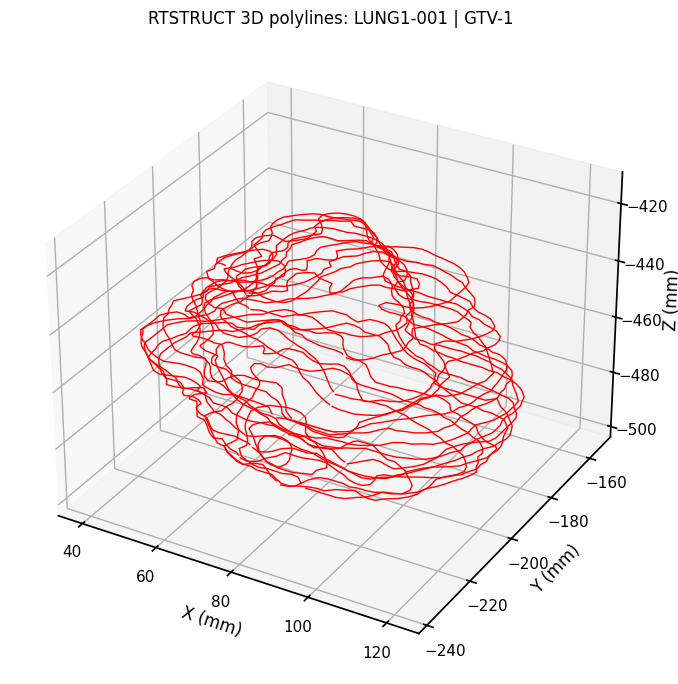

Polylines rendered: 21 | ROI: GTV-1


In [8]:
# Standalone 3D render of RTSTRUCT (contours only, no CT)
# Renders the selected ROI's contour polylines in patient coordinates (mm).

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sid = "LUNG1-001" # Default Subject for Lung1

# ================================

# Use same subject if defined, else pick first with RTSTRUCT
try:
    sid_rt_only = sid
except NameError:
    sid_rt_only = inventory[inventory["has_RTSTRUCT"]]["Subject ID"].iloc[0]

print("RTSTRUCT-only render subject:", sid_rt_only)

rs_rows = df_rs[df_rs["Subject ID"] == sid_rt_only]
if rs_rows.empty:
    print("No RTSTRUCT for subject.")
else:
    rs_path = safe_first_dcm_in_dir(rs_rows.iloc[0]["series_dir"])
    if rs_path is None:
        print("No RTSTRUCT DICOM found.")
    else:
        ds_rs = pydicom.dcmread(str(rs_path), stop_before_pixels=True)
        # Choose ROI (prefer GTV)
        roi_map = {}
        try:
            for roi in ds_rs.StructureSetROISequence:
                roi_map[roi.ROINumber] = str(getattr(roi, "ROIName", ""))
        except Exception:
            pass
        gtv_numbers = [num for num, name in roi_map.items() if "gtv" in name.lower()]
        target_roi = gtv_numbers[0] if gtv_numbers else (sorted(roi_map.keys())[0] if roi_map else None)
        roi_name = roi_map.get(target_roi, "ROI")

        # Gather 3D contour polylines (mm)
        polylines = []
        try:
            for rc in ds_rs.ROIContourSequence:
                if getattr(rc, "ReferencedROINumber", None) != target_roi:
                    continue
                for cs in getattr(rc, "ContourSequence", []) or []:
                    pts = np.array(cs.ContourData, dtype=float).reshape(-1, 3)
                    polylines.append(pts)
        except Exception as e:
            print("Failed to parse contours:", e)

        if not polylines:
            print("No contour polylines found for:", roi_name)
        else:
            # Plot in 3D
            fig = plt.figure(figsize=(7, 7))
            ax = fig.add_subplot(111, projection='3d')
            for pts in polylines:
                ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], 'r-', linewidth=1)
            ax.set_title(f"RTSTRUCT 3D polylines: {sid_rt_only} | {roi_name}")
            ax.set_xlabel('X (mm)')
            ax.set_ylabel('Y (mm)')
            ax.set_zlabel('Z (mm)')
            # Equal aspect for 3D
            all_pts = np.vstack(polylines)
            mins = all_pts.min(axis=0)
            maxs = all_pts.max(axis=0)
            centers = (mins + maxs) / 2.0
            ranges = (maxs - mins)
            radius = ranges.max() / 2.0
            ax.set_xlim(centers[0] - radius, centers[0] + radius)
            ax.set_ylim(centers[1] - radius, centers[1] + radius)
            ax.set_zlim(centers[2] - radius, centers[2] + radius)
            plt.tight_layout()
            plt.show()
            print(f"Polylines rendered: {len(polylines)} | ROI: {roi_name}")


### Interpretation

* The countours roughly align with each other to form a plausible tumor shape

## Tumor Volume Calculation - Contour method

Subject: LUNG1-001
Available ROIs: ['GTV-1', 'Spinal-Cord', 'Lung-Left', 'Lung-Right'] 
Chosen ROI: GTV-1 (ROINumber=2)
Contours collected: 21 across 21 slices


{
│   'row_spacing_mm': 0.9765625,
│   'col_spacing_mm': 0.9765625,
│   'dz_median_mm': 3.0,
│   'num_slices_stack': 134,
│   'num_slices_mask_nonzero': 21,
│   'volume_mm3': 162039.75677490234,
│   'volume_ml': 162.03975677490234,
│   'roi_used': 'GTV-1'
}

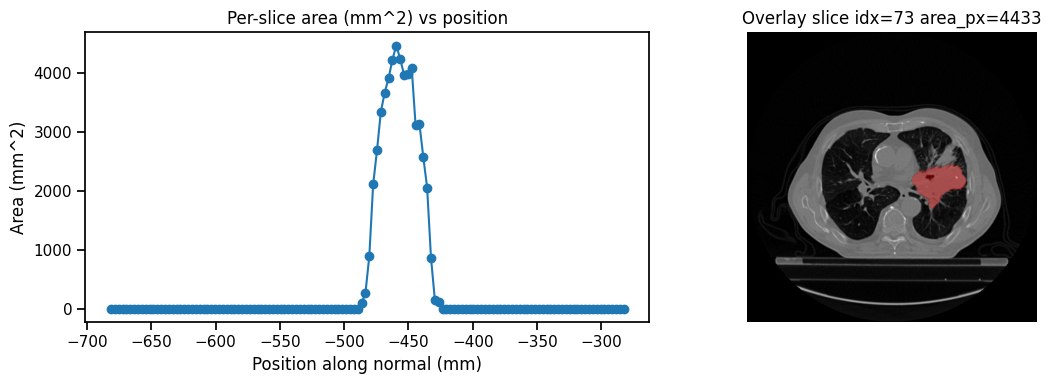

In [9]:
# RTSTRUCT → voxel mask → tumor volume (TPS-like voxelization)
# Steps: pick ROI → match CT stack → build mask on native grid → compute volume

from skimage.draw import polygon as sk_polygon
import numpy.linalg as npl
import re

# Choose subject and ROI (prefer GTV)
try:
    sid_vol = sid
except NameError:
    sid_vol = inventory[(inventory["has_CT"]) & (inventory["has_RTSTRUCT"])]["Subject ID"].iloc[0]
print("Subject:", sid_vol)

rs_rows = df_rs[df_rs["Subject ID"] == sid_vol]
ct_rows = df_ct[df_ct["Subject ID"] == sid_vol]
assert not rs_rows.empty and not ct_rows.empty, "Missing CT or RTSTRUCT for subject"

rs_path = safe_first_dcm_in_dir(rs_rows.iloc[0]["series_dir"])
assert rs_path is not None, "RTSTRUCT DICOM not found"

ds_rs = pydicom.dcmread(str(rs_path), stop_before_pixels=True)

# ROI select
roi_map = {}
try:
    for roi in ds_rs.StructureSetROISequence:
        roi_map[roi.ROINumber] = str(getattr(roi, 'ROIName', ''))
except Exception:
    pass
print("Available ROIs:", list(roi_map.values())[:6], ("..." if len(roi_map) > 6 else ""))

# ROI picking logic with optional overrides
roi_number_override = globals().get('roi_number_override', None)
# roi_name_regex = globals().get('roi_name_regex', None)
roi_name_regex = r"^(GTV|GTVp|GTV-?1)"

if roi_number_override is not None:
    roi_number = int(roi_number_override)
else:
    candidates = list(roi_map.keys())
    if roi_name_regex:
        pattern = re.compile(str(roi_name_regex), flags=re.IGNORECASE)
        filtered = [num for num, nm in roi_map.items() if pattern.search(nm or "")]
        if filtered:
            candidates = filtered
    gtv_numbers = [num for num, name in roi_map.items() if 'gtv' in (name or '').lower()]
    if gtv_numbers:
        roi_number = gtv_numbers[0]
    else:
        roi_number = candidates[0] if candidates else None

roi_name = roi_map.get(roi_number, "ROI")
print("Chosen ROI:", roi_name, f"(ROINumber={roi_number})")

# Collect contours per referenced SOPInstanceUID (mm coords)
uid_to_pts_list = {}
num_polys = 0
for rc in getattr(ds_rs, 'ROIContourSequence', []) or []:
    if getattr(rc, 'ReferencedROINumber', None) != roi_number:
        continue
    for cs in getattr(rc, 'ContourSequence', []) or []:
        pts = np.array(cs.ContourData, dtype=float).reshape(-1, 3)
        cis = getattr(cs, 'ContourImageSequence', []) or []
        if not cis:
            continue
        ref_uid = str(getattr(cis[0], 'ReferencedSOPInstanceUID', ''))
        uid_to_pts_list.setdefault(ref_uid, []).append(pts)
        num_polys += 1
print(f"Contours collected: {num_polys} across {len(uid_to_pts_list)} slices")

# Index CT slices minimally → pick the exact CT series referenced by the RTSTRUCT
ct_index = {}  # SOPInstanceUID → (SeriesInstanceUID, path)
series_to_sops = {}
for _, row in ct_rows.iterrows():
    for dcm_path in row["series_dir"].rglob("*.dcm"):
        try:
            ds = pydicom.dcmread(str(dcm_path), stop_before_pixels=True, specific_tags=["SOPInstanceUID", "SeriesInstanceUID"])  # minimal read
            sop = str(getattr(ds, "SOPInstanceUID", ""))
            ser = str(getattr(ds, "SeriesInstanceUID", ""))
            ct_index[sop] = (ser, str(dcm_path))
            series_to_sops.setdefault(ser, []).append(sop)
        except Exception:
            continue

# Determine target CT series from any referenced SOPInstanceUID
ref_uids = list(uid_to_pts_list.keys())
ref_series_uid = None
for u in ref_uids:
    if u in ct_index:
        ref_series_uid = ct_index[u][0]
        break
assert ref_series_uid is not None, "Could not find referenced CT series for RTSTRUCT"

# Read full slices for ONLY the referenced series using SimpleITK series ordering
# Determine a representative path for the referenced series to locate the directory
rep_sop = next(u for u in ref_uids if u in ct_index)
rep_path = Path(ct_index[rep_sop][1])
series_dir = str(rep_path.parent)

reader = sitk.ImageSeriesReader()
series_ids = reader.GetGDCMSeriesIDs(series_dir)
assert series_ids, "No DICOM series found under directory for referenced series"
# Find the SimpleITK series id matching the referenced SeriesInstanceUID; fallback to first
sitk_series_id = ref_series_uid if ref_series_uid in series_ids else series_ids[0]
sitk_files = reader.GetGDCMSeriesFileNames(series_dir, sitk_series_id)

all_slices = []
for fp in sitk_files:
    try:
        ds = pydicom.dcmread(fp)  # full read to access pixels later
        all_slices.append(ds)
    except Exception:
        continue
assert len(all_slices) > 0, "No CT slices from referenced series read"

# Convenience map for later UID lookups within this series only
uid_to_ds = {str(getattr(ds, "SOPInstanceUID", "")): ds for ds in all_slices}

# Sort stack along slice normal using IOP
first = all_slices[0]
iop = np.array(first.ImageOrientationPatient, dtype=float)
row_dir, col_dir = iop[:3], iop[3:]
normal = np.cross(row_dir, col_dir)

def slice_pos(ds):
    ipp = np.array(ds.ImagePositionPatient, dtype=float)
    return float(np.dot(ipp, normal))

all_slices_sorted = sorted(all_slices, key=slice_pos)
z_positions = np.array([slice_pos(ds) for ds in all_slices_sorted], dtype=float)
# Compute per-slice dz (last slice repeats previous)
dz = np.diff(z_positions)
dz = np.r_[dz, dz[-1] if dz.size else 0.0]

H, W = int(first.Rows), int(first.Columns)
row_sp, col_sp = [float(x) for x in first.PixelSpacing]
# Build mask via rt-utils on the exact referenced CT series (SITK order)
from rt_utils import RTStructBuilder

rt = RTStructBuilder.create_from(dicom_series_path=series_dir, rt_struct_path=str(rs_path))
roi_names = rt.get_roi_names()
roi_pat = re.compile(r"^(GTV|GTVp|GTV-?1)", re.I)
roi_to_use = roi_name if roi_name in roi_names else next((n for n in roi_names if roi_pat.search(n)), roi_names[0])
mask_rt = rt.get_roi_mask_by_name(roi_to_use)

# Reorient mask so axis 0 == z (same as sitk_files order), and ensure (z,y,x)
shape = mask_rt.shape
slice_axis = shape.index(len(sitk_files)) if len(sitk_files) in shape else (len(shape) - 1)
mask_z = np.moveaxis(mask_rt, slice_axis, 0)
if mask_z.shape[1:] != (H, W):
    # transpose in-plane if needed
    mask_z = np.transpose(mask_z, (0, 2, 1))

mask = mask_z.astype(bool)

# Compute volume via per-slice area * dz_i (mm^3 → mL)
areas_px = mask.reshape(len(all_slices_sorted), -1).sum(axis=1)
areas_mm2 = areas_px * (row_sp * col_sp)
vol_mm3 = np.sum(areas_mm2 * dz)
vol_ml = vol_mm3 / 1000.0

pprint({
    'row_spacing_mm': row_sp,
    'col_spacing_mm': col_sp,
    'dz_median_mm': float(np.median(np.diff(z_positions))) if len(z_positions) > 1 else 0.0,
    'num_slices_stack': len(all_slices_sorted),
    'num_slices_mask_nonzero': int((areas_px > 0).sum()),
    'volume_mm3': float(vol_mm3),
    'volume_ml': float(vol_ml),
    'roi_used': roi_to_use,
})

# Plots: area vs z and a few overlays for QC
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(z_positions, areas_mm2, '-o')
axes[0].set_title('Per-slice area (mm^2) vs position')
axes[0].set_xlabel('Position along normal (mm)')
axes[0].set_ylabel('Area (mm^2)')

# Show up to 3 slices with overlays (SITK order)
shown = 0
for idx in np.argsort(-areas_px):
    if areas_px[idx] <= 0 or shown >= 3:
        continue
    ds_full = pydicom.dcmread(sitk_files[idx])
    img = ds_full.pixel_array
    axes[1].imshow(img, cmap='gray')
    m = mask[idx]
    axes[1].imshow(np.ma.masked_where(~m, m), cmap='autumn', alpha=0.35)
    axes[1].set_title(f'Overlay slice idx={idx} area_px={int(areas_px[idx])}')
    axes[1].axis('off')
    shown += 1
plt.tight_layout()
plt.show()


### Interpretation

* We calculated the tumor volume by summing the area of the segmented region in each image slice, then multiplying each by the slice thickness to obtain per-slice volumes (in mm³).
* This was then converted to milliliters (mL). The per-slice areas were derived by counting the number of mask pixels per slice and multiplying by pixel area from DICOM metadata.
* Visualizations of area vs position, and example overlays, confirmed the mask's anatomical alignment and provided a QC check for segmentation plausibility.

Importantly, the mask is built by rt-utils directly on the referenced CT series (no resampling), then only reoriented to (z,y,x) to match slice order. The in-plane size is checked and, if needed, transposed to match (Rows, Cols); no resample of spacing occurs.

True spacings are used:
* In-plane spacing: row_sp, col_sp are taken from the CT’s PixelSpacing on the matched series.
* Slice spacing: dz is computed from differences of ImagePositionPatient projected onto the slice normal (from ImageOrientationPatient), not from SliceThickness. Volume is Σ(area_mm2[i] × dz[i]) / 1000.

So the volume is computed on the native DICOM grid with native PixelSpacing and geometry-derived Δz. This should match the standard voxel counting method.

## Tumor Volume Calculation - Voxel Method Comparison

In [10]:
# Tumor volume via voxel counting on native grid (mask voxels × voxel volume)
# Uses the same SITK-locked order (ct_files), PixelSpacing, and per-gap dz derived from IPP·n.

# Ensure prerequisites exist: mask (z,y,x), row_sp, col_sp, dz, areas_mm2
assert 'mask' in globals() and 'dz' in globals()

# Per-slice voxel counts
voxels_per_slice = mask.reshape(mask.shape[0], -1).sum(axis=1)
voxel_vol_mm3_per_slice = float(row_sp * col_sp) * dz
vol_mm3_voxel = float(np.sum(voxels_per_slice * voxel_vol_mm3_per_slice))
vol_ml_voxel = vol_mm3_voxel / 1000.0

# Compare with area-integration result (vol_ml)
result = {
    'volume_ml_voxel_count': vol_ml_voxel,
    'volume_ml_area_integration': vol_ml,
    'delta_ml': float(vol_ml_voxel - vol_ml),
    'rel_delta_pct': float(100.0 * (vol_ml_voxel - vol_ml) / (vol_ml + 1e-6)) if vol_ml > 0 else None,
}
pprint(result)


{
│   'volume_ml_voxel_count': 162.03975677490234,
│   'volume_ml_area_integration': np.float64(162.03975677490234),
│   'delta_ml': 0.0,
│   'rel_delta_pct': 0.0
}

### Interpretation

* Both voxel counting and area-integration result in exactly the same volume
* Since both methods are on the native CT grid with a binary mask, it’s normal (and mathematically expected) that the two methods match exactly (down to floating-point)

## Overlay Anatomy Matching

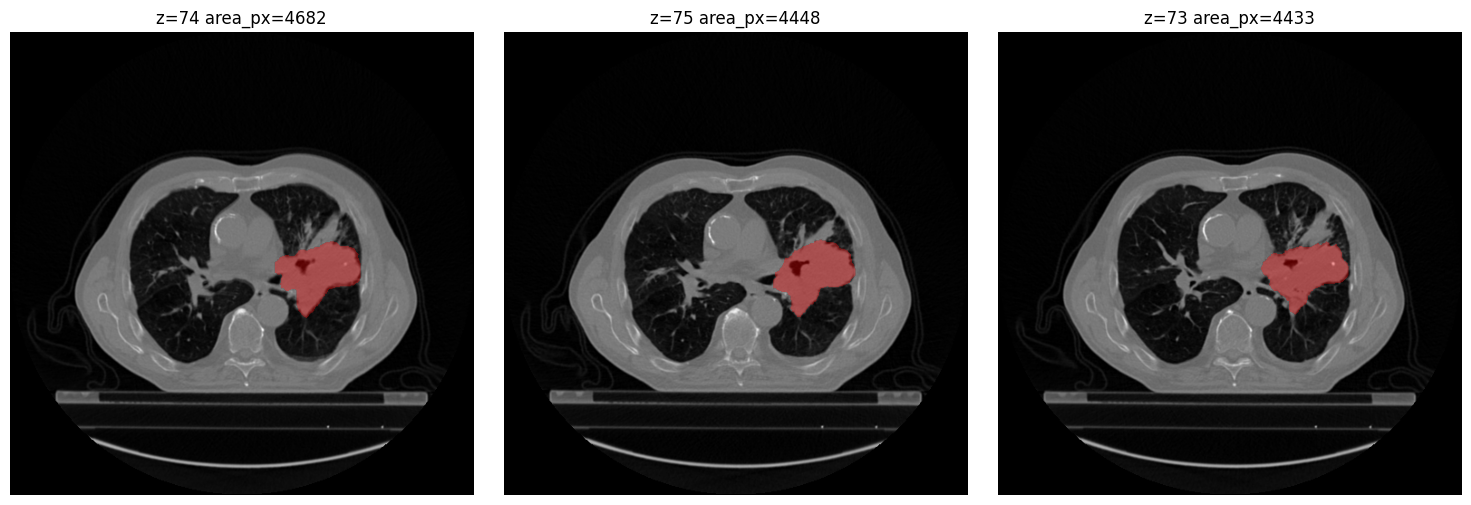

In [11]:
ct_files = list(sitk_files)

# Overlays (top-3) with locked order
areas_rt = mask_z.reshape(mask_z.shape[0], -1).sum(axis=1)
order = np.argsort(-areas_rt)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    if i >= len(order) or areas_rt[order[i]] == 0:
        ax.axis('off'); continue
    z = int(order[i])
    ds = pydicom.dcmread(ct_files[z])
    ax.imshow(ds.pixel_array, cmap='gray')
    ax.imshow(np.ma.masked_where(mask_z[z] == 0, mask_z[z]), cmap='autumn', alpha=0.35)
    ax.set_title(f'z={z} area_px={int(areas_rt[z])}')
    ax.axis('off')
plt.tight_layout(); plt.show()

### Interpretation

* The RTSTRUCT mask overlays (red) align precisely with tumor regions on the underlying CT images.
* All highlighted masks are well-localized to visible lesions, with no gross spatial mismatches.
* This confirms the RTSTRUCT contours are correctly registered to the CT voxel grid for these cases.

## Summary & Gate

- Inventoried DICOM series and computed coverage for CT and RTSTRUCT.
- Validated clinical CSV joinability and sampled CT metadata distributions.
- Checked CT↔RTSTRUCT FrameOfReferenceUID alignment on a representative subset.
- Rendered a representative RTSTRUCT of a tumor for visual sanity checking.
- Calculated per-slice area and tumor volume for one tumor
- Rendered overlays of neighboring slices to visually confirm alignment with anatomy. 

If any assertion failed above, the dataset needs attention before proceeding to Data Preparation.

## APPENDIX: 3D Interacive Visualization

In [ ]:
# Helpers for SEG→CT mapping (SOPInstanceUID-based)
from typing import Set, Optional

def seg_referenced_sops(ds_seg: pydicom.dataset.FileDataset) -> Set[str]:
    uids: Set[str] = set()
    pfs = getattr(ds_seg, 'PerFrameFunctionalGroupsSequence', []) or []
    for pf in pfs:
        for der in getattr(pf, 'DerivationImageSequence', []) or []:
            for src in getattr(der, 'SourceImageSequence', []) or []:
                uid = getattr(src, 'ReferencedSOPInstanceUID', None)
                if uid:
                    uids.add(str(uid))
        for ref in getattr(pf, 'ReferencedImageSequence', []) or []:
            uid = getattr(ref, 'ReferencedSOPInstanceUID', None)
            if uid:
                uids.add(str(uid))
    return uids


def find_ct_series_matching_sops(ct_rows: pd.DataFrame, sops: Set[str]) -> Optional[pd.Series]:
    if not sops:
        return None
    for _, row in ct_rows.iterrows():
        series_dir: Path = row["series_dir"]
        if not series_dir.exists():
            continue
        for dcm_path in series_dir.rglob("*.dcm"):
            try:
                ds = pydicom.dcmread(str(dcm_path), stop_before_pixels=True, specific_tags=["SOPInstanceUID"])
                if str(getattr(ds, "SOPInstanceUID", "")) in sops:
                    return row
            except Exception:
                continue
    return None


In [ ]:
# 3D interactive visualization (CT + contours) for spot checks (fixed viewer)
from importlib.util import find_spec

subjects_seg = inventory[(inventory["has_CT"]) & (inventory["has_SEG"])]["Subject ID"].tolist()
if not subjects_seg:
    print("No subjects with CT+SEG available for 3D overlay.")
else:
    sid = subjects_seg[0]
    print("3D overlay subject:", sid)

    seg_rows = df_seg[df_seg["Subject ID"] == sid]
    seg_path = safe_first_dcm_in_dir(seg_rows.iloc[0]["series_dir"]) if not seg_rows.empty else None
    if seg_path is None:
        print("SEG file not found.")
    else:
        try:
            ds_seg = pydicom.dcmread(str(seg_path))
            sops = seg_referenced_sops(ds_seg)
        except Exception as e:
            ds_seg, sops = None, set()
            print("SEG read failed:", e)

        ct_rows = df_ct[df_ct["Subject ID"] == sid]
        matched_ct = find_ct_series_matching_sops(ct_rows, sops) if sops else choose_preferred_ct_series(ct_rows)
        if matched_ct is None:
            print("Failed to match CT series; cannot visualize.")
        else:
            try:
                reader = sitk.ImageSeriesReader()
                file_names = reader.GetGDCMSeriesFileNames(str(matched_ct["series_dir"]))
                reader.SetFileNames(file_names)
                ct_img = reader.Execute()
            except Exception as e:
                ct_img = None
                print("CT load failed:", e)
            try:
                seg_img = sitk.ReadImage(str(seg_path))
            except Exception as e:
                seg_img = None
                print("SEG load failed:", e)

            if ct_img is None or seg_img is None:
                print("Missing CT or SEG image for visualization.")
            else:
                seg_to_ct = sitk.Resample(
                    seg_img,
                    ct_img,
                    sitk.Transform(),
                    sitk.sitkNearestNeighbor,
                    0,
                    sitk.sitkUInt8,
                )

                if find_spec("itkwidgets") is not None:
                    from itkwidgets import view
                    # Convert to arrays to avoid ITK template type issues
                    ct_np = sitk.GetArrayFromImage(ct_img).astype(np.float32)
                    ct_np = np.clip(ct_np, -1000.0, 400.0)
                    ct_np = (ct_np + 1000.0) / (400.0 + 1000.0 + 1e-6)
                    seg_np = sitk.GetArrayFromImage(seg_to_ct).astype(np.uint8)
                    sx, sy, sz = ct_img.GetSpacing()
                    spacing = (sz, sy, sx)  # z, y, x for array
                    from IPython.display import display
                    viewer = view(image=ct_np,
                                   spacing=spacing,
                                   label_image=seg_np,
                                   label_image_names=['SEG'],
                                   label_image_weights=np.array([1.0], dtype=np.float32),
                                   gradient_opacity=0.15,
                                   label_image_blend=0.35,
                                   cmap='Grayscale',
                                   ui_collapsed=False)
                    display(viewer)
                else:
                    out_dir = ROOT / "data" / "interim" / f"slicer_export_{sid}"
                    out_dir.mkdir(parents=True, exist_ok=True)
                    ct_nii = out_dir / "ct.nii.gz"
                    seg_nii = out_dir / "seg.nii.gz"
                    sitk.WriteImage(ct_img, str(ct_nii), useCompression=True)
                    sitk.WriteImage(seg_to_ct, str(seg_nii), useCompression=True)
                    print("itkwidgets not available. Wrote NIfTI for Slicer:")
                    print("  CT:", ct_nii)
                    print("  SEG:", seg_nii)
                    print("Open both in 3D Slicer and set the SEG as a label map to inspect.")
